# Jacobian Determinant

$$
J = \text{det}(\mathbf{J}),
$$
where $\mathbf{J}$ is the Jacobian matrix of partial derivatives. Each element of $\mathbf{J}$, denoted as $J_{ij}$, represents the partial derivative of the transformed variable $x'_i$ with respect to the original variable $x_j$. For an $n$-dimensional transformation from variables $\mathbf{x}$ to $\mathbf{x'}$ using a function $\mathbf{f}(\mathbf{x}) = \mathbf{x'}$, the Jacobian matrix is defined as:

$$
\mathbf{J} = \left[\begin{array}{ccc}
\frac{\partial x'_1}{\partial x_1} & \cdots & \frac{\partial x'_1}{\partial x_n} \\
\vdots & \ddots & \vdots \\
\frac{\partial x'_n}{\partial x_1} & \cdots & \frac{\partial x'_n}{\partial x_n}
\end{array}\right].
$$

In [2]:
import numpy as np
from scipy.optimize import approx_fprime

# Define the transformation functions
def transform(parameters):
    mass_1, mass_2, theta_jn, dl_1, dl_2, dt_12 = parameters
    mass_1_prime = mass_1 * 1.05
    mass_2_prime = mass_2 * 0.95
    theta_jn_prime = theta_jn + np.pi / 10
    dl_1_prime = dl_1 * 1.1
    dl_2_prime = dl_2 * 0.9
    dt_12_prime = dt_12 + 5
    return np.array([mass_1_prime, mass_2_prime, theta_jn_prime, dl_1_prime, dl_2_prime, dt_12_prime])

# Define a point at which to evaluate the Jacobian
parameters = np.array([30, 20, np.pi/4, 400, 300, 10])  # Example parameters

# Numerical computation of the Jacobian matrix
epsilon = np.sqrt(np.finfo(float).eps)
jacobian_matrix = np.zeros((6, 6))

for i in range(6):
    def wrapper_func(x):
        return transform(np.concatenate([parameters[:i], [x[0]], parameters[i+1:]]))
    jacobian_matrix[:, i] = approx_fprime([parameters[i]], wrapper_func, epsilon).flatten()

# Compute the determinant of the Jacobian matrix
jacobian_determinant = np.linalg.det(jacobian_matrix)

jacobian_determinant

0.9875255333639604

In [2]:
import numpy as np
from pobs.utils import get_param_from_json, save_json, load_json, plot
from pobs.modelgenerator import ModelGenerator
from ler.utils import append_json
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
import corner
import matplotlib.lines as mlines
import h5py 
import pandas as pd
import json
import pickle

Setting multiprocessing start method to 'fork'


## Define all scaling functions

In [3]:
import scipy.stats as stats
from scipy.stats import norm

def uniform_to_gaussian(x, mu=0, sigma=1, upper_bound=0.8, lower_bound=0):
    # Transform to U(0,1)
    U = x / abs(upper_bound - lower_bound)

    # Transform to standard normal
    Z = norm.ppf(U)

    # If you want a normal distribution with mean mu and standard deviation sigma
    X = mu + sigma * Z
    return X

def gaussian_to_uniform(X, mu=0, sigma=1, upper_bound=0.8, lower_bound=0):
    # Reverse the normal scaling to standard normal
    Z = (X - mu) / sigma

    # Transform standard normal back to U(0,1)
    U = norm.cdf(Z)

    # Scale U(0,1) back to U(0, 0.8)
    x = abs(upper_bound - lower_bound) * U
    return x

def sine_to_gaussian(X):
    uniform = (np.cos(X) + 1) / 2  # Convert to Uniform[0, 1]
    gaussian = norm.ppf(uniform)  # Apply the inverse CDF of the Gaussian distribution
    return gaussian

def gaussian_to_sine(X):
    uniform = norm.cdf(X)  # Apply the CDF of the Gaussian distribution
    sine = np.arccos(2 * uniform - 1)  # Convert to the sine of the angle
    return sine

def cosine_to_gaussian(X):
    uniform = (np.sin(X) + 1) / 2  # Convert to Uniform[0, 1]
    gaussian = norm.ppf(uniform)  # Apply the inverse CDF of the Gaussian distribution
    return gaussian

def gaussian_to_cosine(X):
    uniform = norm.cdf(X)  # Apply the CDF of the Gaussian distribution
    cosine = np.arcsin(2 * uniform - 1)  # Convert to the cosine of the angle
    return cosine

def scale_to_range(X, min_data=None, max_data=None, min_target=0+0.0001, max_target=np.pi-0.0001):
    if min_data is None:
        min_data = np.min(X)
    if max_data is None:
        max_data = np.max(X)
    X_std = (X - min_data) / (max_data - min_data)
    X_scaled = X_std * (max_target - min_target) + min_target
    return X_scaled

def unscale_to_range(X, min_data, max_data, min_target=0+0.0001, max_target=np.pi-0.0001):
    X_scaled = (X - min_target) / (max_target - min_target)
    X_unscaled = X_scaled * (max_data - min_data) + min_data
    return X_unscaled

# for saving min max values for scaling as json
def save_min_max(data_dict, filename):
    min_max = {}
    for key, value in data_dict.items():
        min_max[key] = dict(
            min_data = np.min(value), 
            max_data = np.max(value),
        )
    save_json(filename, min_max)

In [4]:
def get_model_and_scaler(model_path, scaler_path, min_max_path=None, dir='ler_data'):
    
    with open(dir+'/'+model_path, 'rb') as f:
        dpgmm = pickle.load(f)

    with open(dir+'/'+scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    if min_max_path is not None:
        min_max = load_json(dir+'/'+min_max_path)
        return dpgmm, scaler, min_max
    else:
        return dpgmm, scaler

## Astrophysical parameter distributions

## Lensed events

* $P_{astro}(m_{1}, m_{2}, \alpha, \delta, \iota, \chi_{eff}, d_{L,1}, d_{L,2}, \Delta T_2|H_L)$

In [5]:
def data_check_astro_lensed(data_dict):

    lensed_param = {}

    param_list = ['ra', 'dec', 'theta_jn', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'mass_1', 'mass_2', 'effective_luminosity_distance', 'effective_geocent_time', 'optimal_snr_net']
    for key in param_list:
        try:
            lensed_param[key] = np.array(data_dict[key])
        except:
            print(f"data_dict should have the following keys: {param_list}")
            raise ValueError(f"{key} is not present in the data_dict")

    # seperate out image 1, 2
    # this is wrt to time of arrival
    lensed_param_1 = {}
    lensed_param_2 = {}

    for key, value in lensed_param.items():
        if np.shape(np.shape(value))[0]==2:
            lensed_param_1[key] = np.array(value)[:,0]
            lensed_param_2[key] = np.array(value)[:,1]
        else:
            lensed_param_1[key] = np.array(value)
            lensed_param_2[key] = np.array(value)

    # For image 1 and 2 only
    # only keep snr > 8
    idx_snr1 = lensed_param_1['optimal_snr_net'] > 8
    idx_snr2 = lensed_param_2['optimal_snr_net'] > 8
    idx_snr = idx_snr1 & idx_snr2

    data_dict = dict(
        mass_1 = lensed_param_1['mass_1'][idx_snr],
        mass_2 = lensed_param_1['mass_2'][idx_snr],
        ra = lensed_param_1['ra'][idx_snr],
        dec = lensed_param_1['dec'][idx_snr],
        theta_jn = lensed_param_1['theta_jn'][idx_snr],
        dl_1 = lensed_param_1['effective_luminosity_distance'][idx_snr],
        dl_2 = lensed_param_2['effective_luminosity_distance'][idx_snr],
        dt_12 = lensed_param_2['effective_geocent_time'][idx_snr] - lensed_param_1['effective_geocent_time'][idx_snr],
    )

    return data_dict

In [6]:
# get data for detectable events
data_dict = get_param_from_json('/Users/phurailatpamhemantakumar/phd/mypackages/pobs/pobs/data/n_lensed_detectable_bbh_po_spin.json')
lensed_param = data_check_astro_lensed(data_dict)
lensed_param.keys()

dict_keys(['mass_1', 'mass_2', 'ra', 'dec', 'theta_jn', 'dl_1', 'dl_2', 'dt_12'])

In [7]:
# using distance ratio
list3 = ['mass_1', 'mass_2', 'theta_jn', 'log10_dl_1', 'log10_dl_2', 'log10_dt_12_days']
lensed_param3 = {}
lensed_param3['mass_1'] = lensed_param['mass_1']
lensed_param3['mass_2'] = lensed_param['mass_2']
lensed_param3['theta_jn'] = lensed_param['theta_jn']
lensed_param3['dl_1'] = lensed_param['dl_1']
lensed_param3['dl_2'] = lensed_param['dl_2']
lensed_param3['dt_12'] = lensed_param['dt_12']
#lensed_param3['dl_12'] = lensed_param['dl_1'] / lensed_param['dl_2']
#del lensed_param3['dl_2']

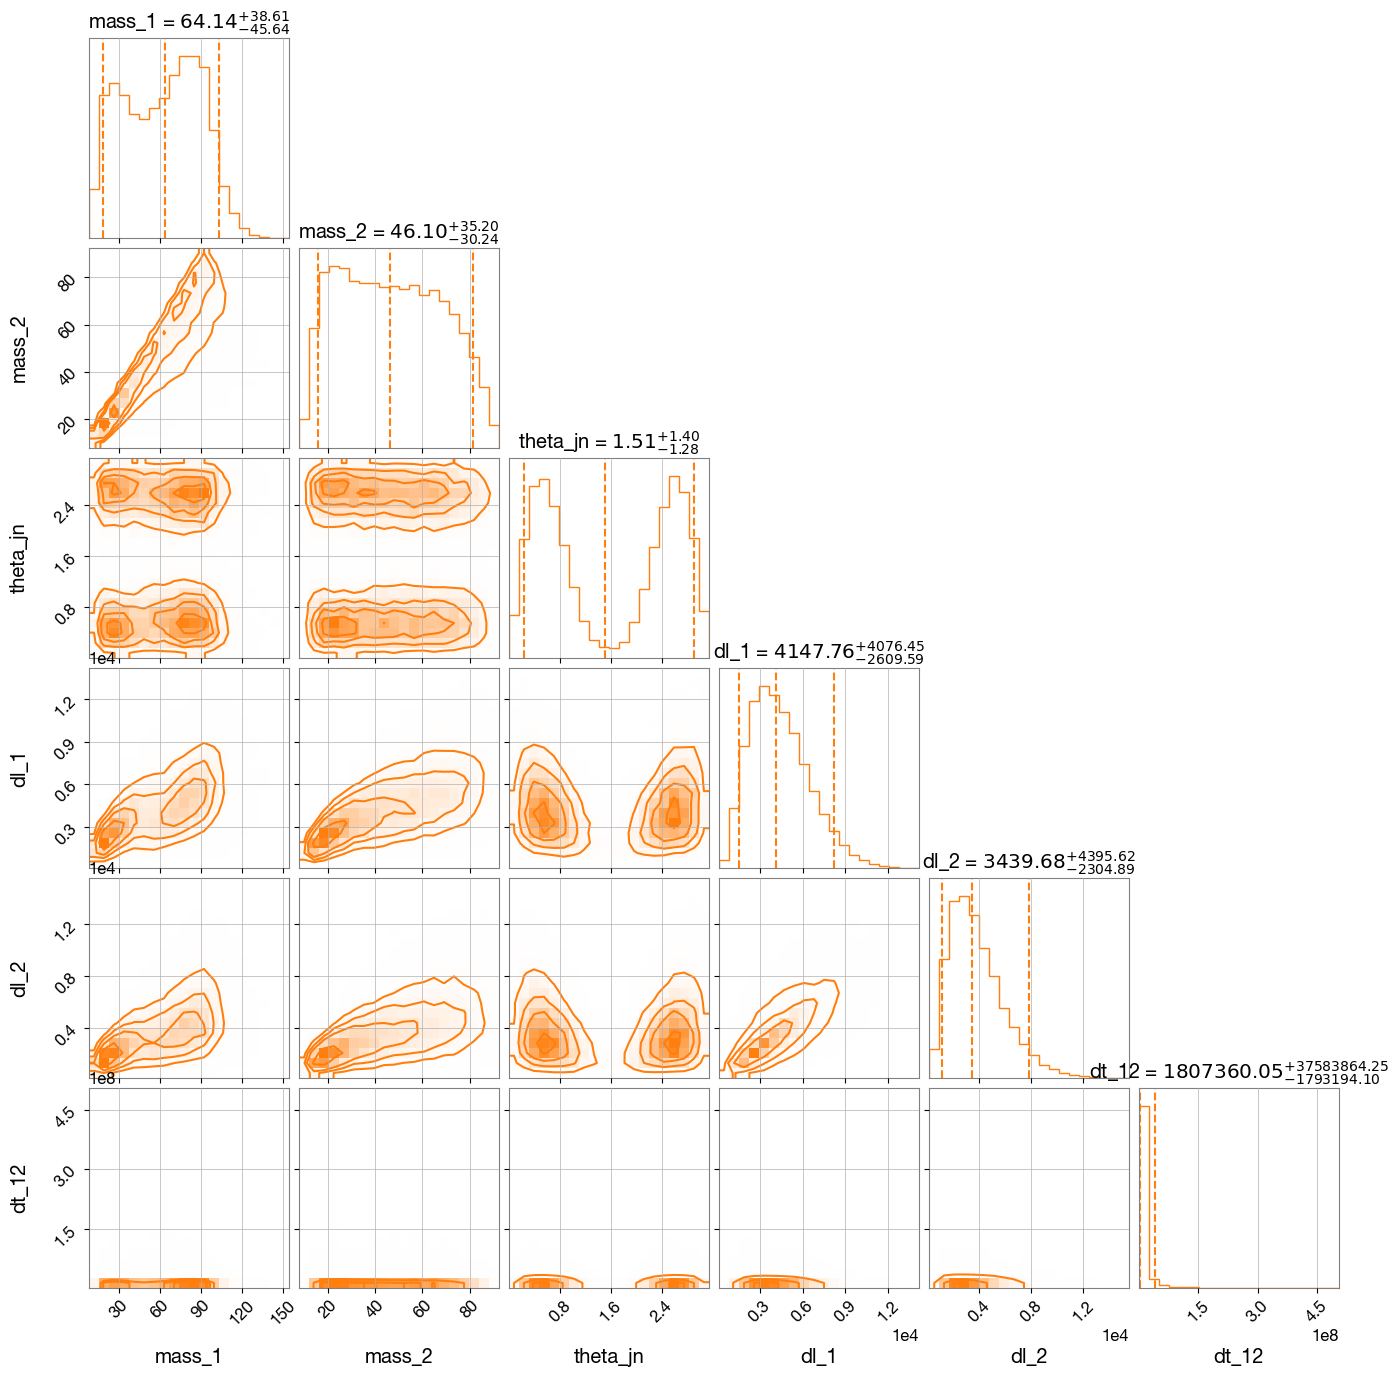

In [8]:
plot(lensed_param3)

In [10]:
list1 = ['mass_1', 'mass_2', 'theta_jn', 'dl_1', 'dl_2', 'dt_12']
list2 = ['ra', 'dec']

lensed_param1 = {key: lensed_param[key] for key in list1}
lensed_param2 = {key: lensed_param[key] for key in list2}

In [11]:
test1 = ModelGenerator(
    model_name='astro_lensed', 
    data_dict=lensed_param1,
    pobs_directory="./pobs_data",
)
_,_, min_max1 = test1.get_model_scaler_minmax()
test2 = ModelGenerator(
    model_name='astro_lensed_sky', 
    data_dict=lensed_param2,
    pobs_directory="./pobs_data",
)
_,_, min_max2 = test2.get_model_scaler_minmax()
min_max1.keys(), min_max2.keys()

(dict_keys(['mass_1', 'mass_2', 'theta_jn', 'dl_1', 'dl_2', 'dt_12']),
 dict_keys(['ra', 'dec']))

In [36]:
# # what original data looks like
# test1.plot(lensed_param1)
# test2.plot(lensed_param2)

### astro_lensed

In [12]:
# list of dict values
train_data_ = np.array([lensed_param1[key] for key in lensed_param1.keys()]).T
train_data_.shape

(40034, 6)

In [19]:
# scale data

def transform(parameters):

    mass_1, mass_2, theta_jn, dl_1, dl_2, dt_12 = parameters

    # scale m1
    mass_1 = scale_to_range(mass_1, min_max1['mass_1']['min_data'], min_max1['mass_1']['max_data'])
    mass_1 = sine_to_gaussian(mass_1)

    # scale m2
    mass_2 = scale_to_range(mass_2, min_max1['mass_2']['min_data'], min_max1['mass_2']['max_data'])
    mass_2 = sine_to_gaussian(mass_2)

    # scale theta_jn
    theta_jn = sine_to_gaussian(theta_jn)

    # scale dl_1, log10
    dl_1 = np.log10(dl_1)

    # scale dl_2, log10
    dl_2 = np.log10(dl_2)

    # scale dt_12, log10, sec to days
    dt_12 = np.log10(dt_12 / 86400)

    return np.array([mass_1, mass_2, theta_jn, dl_1, dl_2, dt_12])


In [22]:
# get parameters from lensed_param3
parameters = np.array([lensed_param3[key] for key in lensed_param3.keys()])
parameters.shape

(6, 40034)

In [24]:
parameters_ = transform(parameters)
# make dict again
lensed_param_ = {key: parameters_[i] for i, key in enumerate(lensed_param3.keys())}

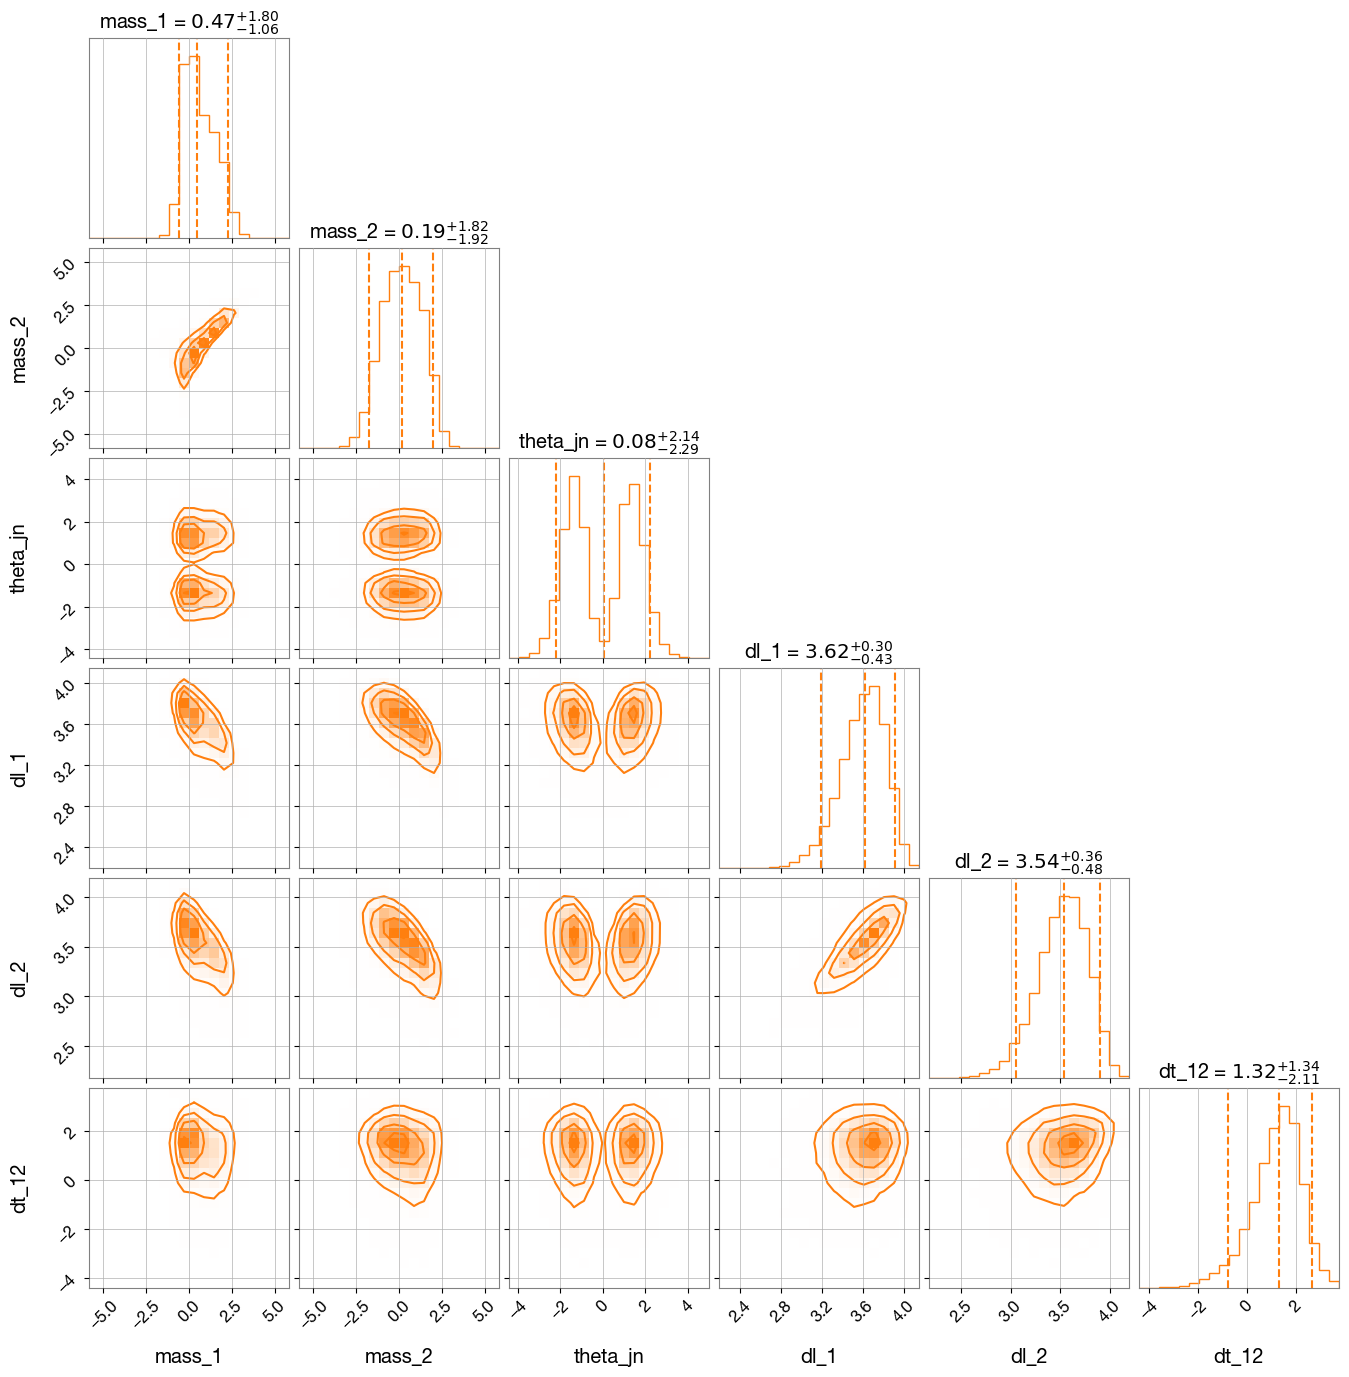

In [25]:
plot(lensed_param_)

In [51]:
# # create a dictionary for the scaled data
# train_data_dict = dict(
#     mass_1 = train_data_[:,0],
#     mass_2 = train_data_[:,1],
#     theta_jn = train_data_[:,2],
#     log10_dl_1 = train_data_[:,3],
#     log10_dl_2 = train_data_[:,4],
#     log10_dt_12_days = train_data_[:,5],
# )
# test1.plot(train_data_dict)

In [54]:
from sklearn.preprocessing import StandardScaler
# Choose a scaler:
scaler = StandardScaler()  # or MinMaxScaler(), RobustScaler()

# Scale the data
scaled_data = scaler.fit_transform(train_data_)

# Fit the model
# Set up the Dirichlet Process Gaussian Mixture Model
dpgmm = BayesianGaussianMixture(
    n_components=10,  # Large enough to capture complexity
    covariance_type='full',  # Each component can have its own covariance
    weight_concentration_prior=1e-1,  # Smaller values encourage more clusters
    max_iter=500,  # Increase for more convergence stability
    random_state=42
    )
# time for training, n_components=20, weight_concentration_prior=1e-2, max_iter=1000: 3m 14.6s
# time for training, n_components=10, weight_concentration_prior=1e-1, max_iter=500: 3m 14.6s
dpgmm.fit(scaled_data)

BayesianGaussianMixture(max_iter=500, n_components=10, random_state=42,
                        weight_concentration_prior=0.1)

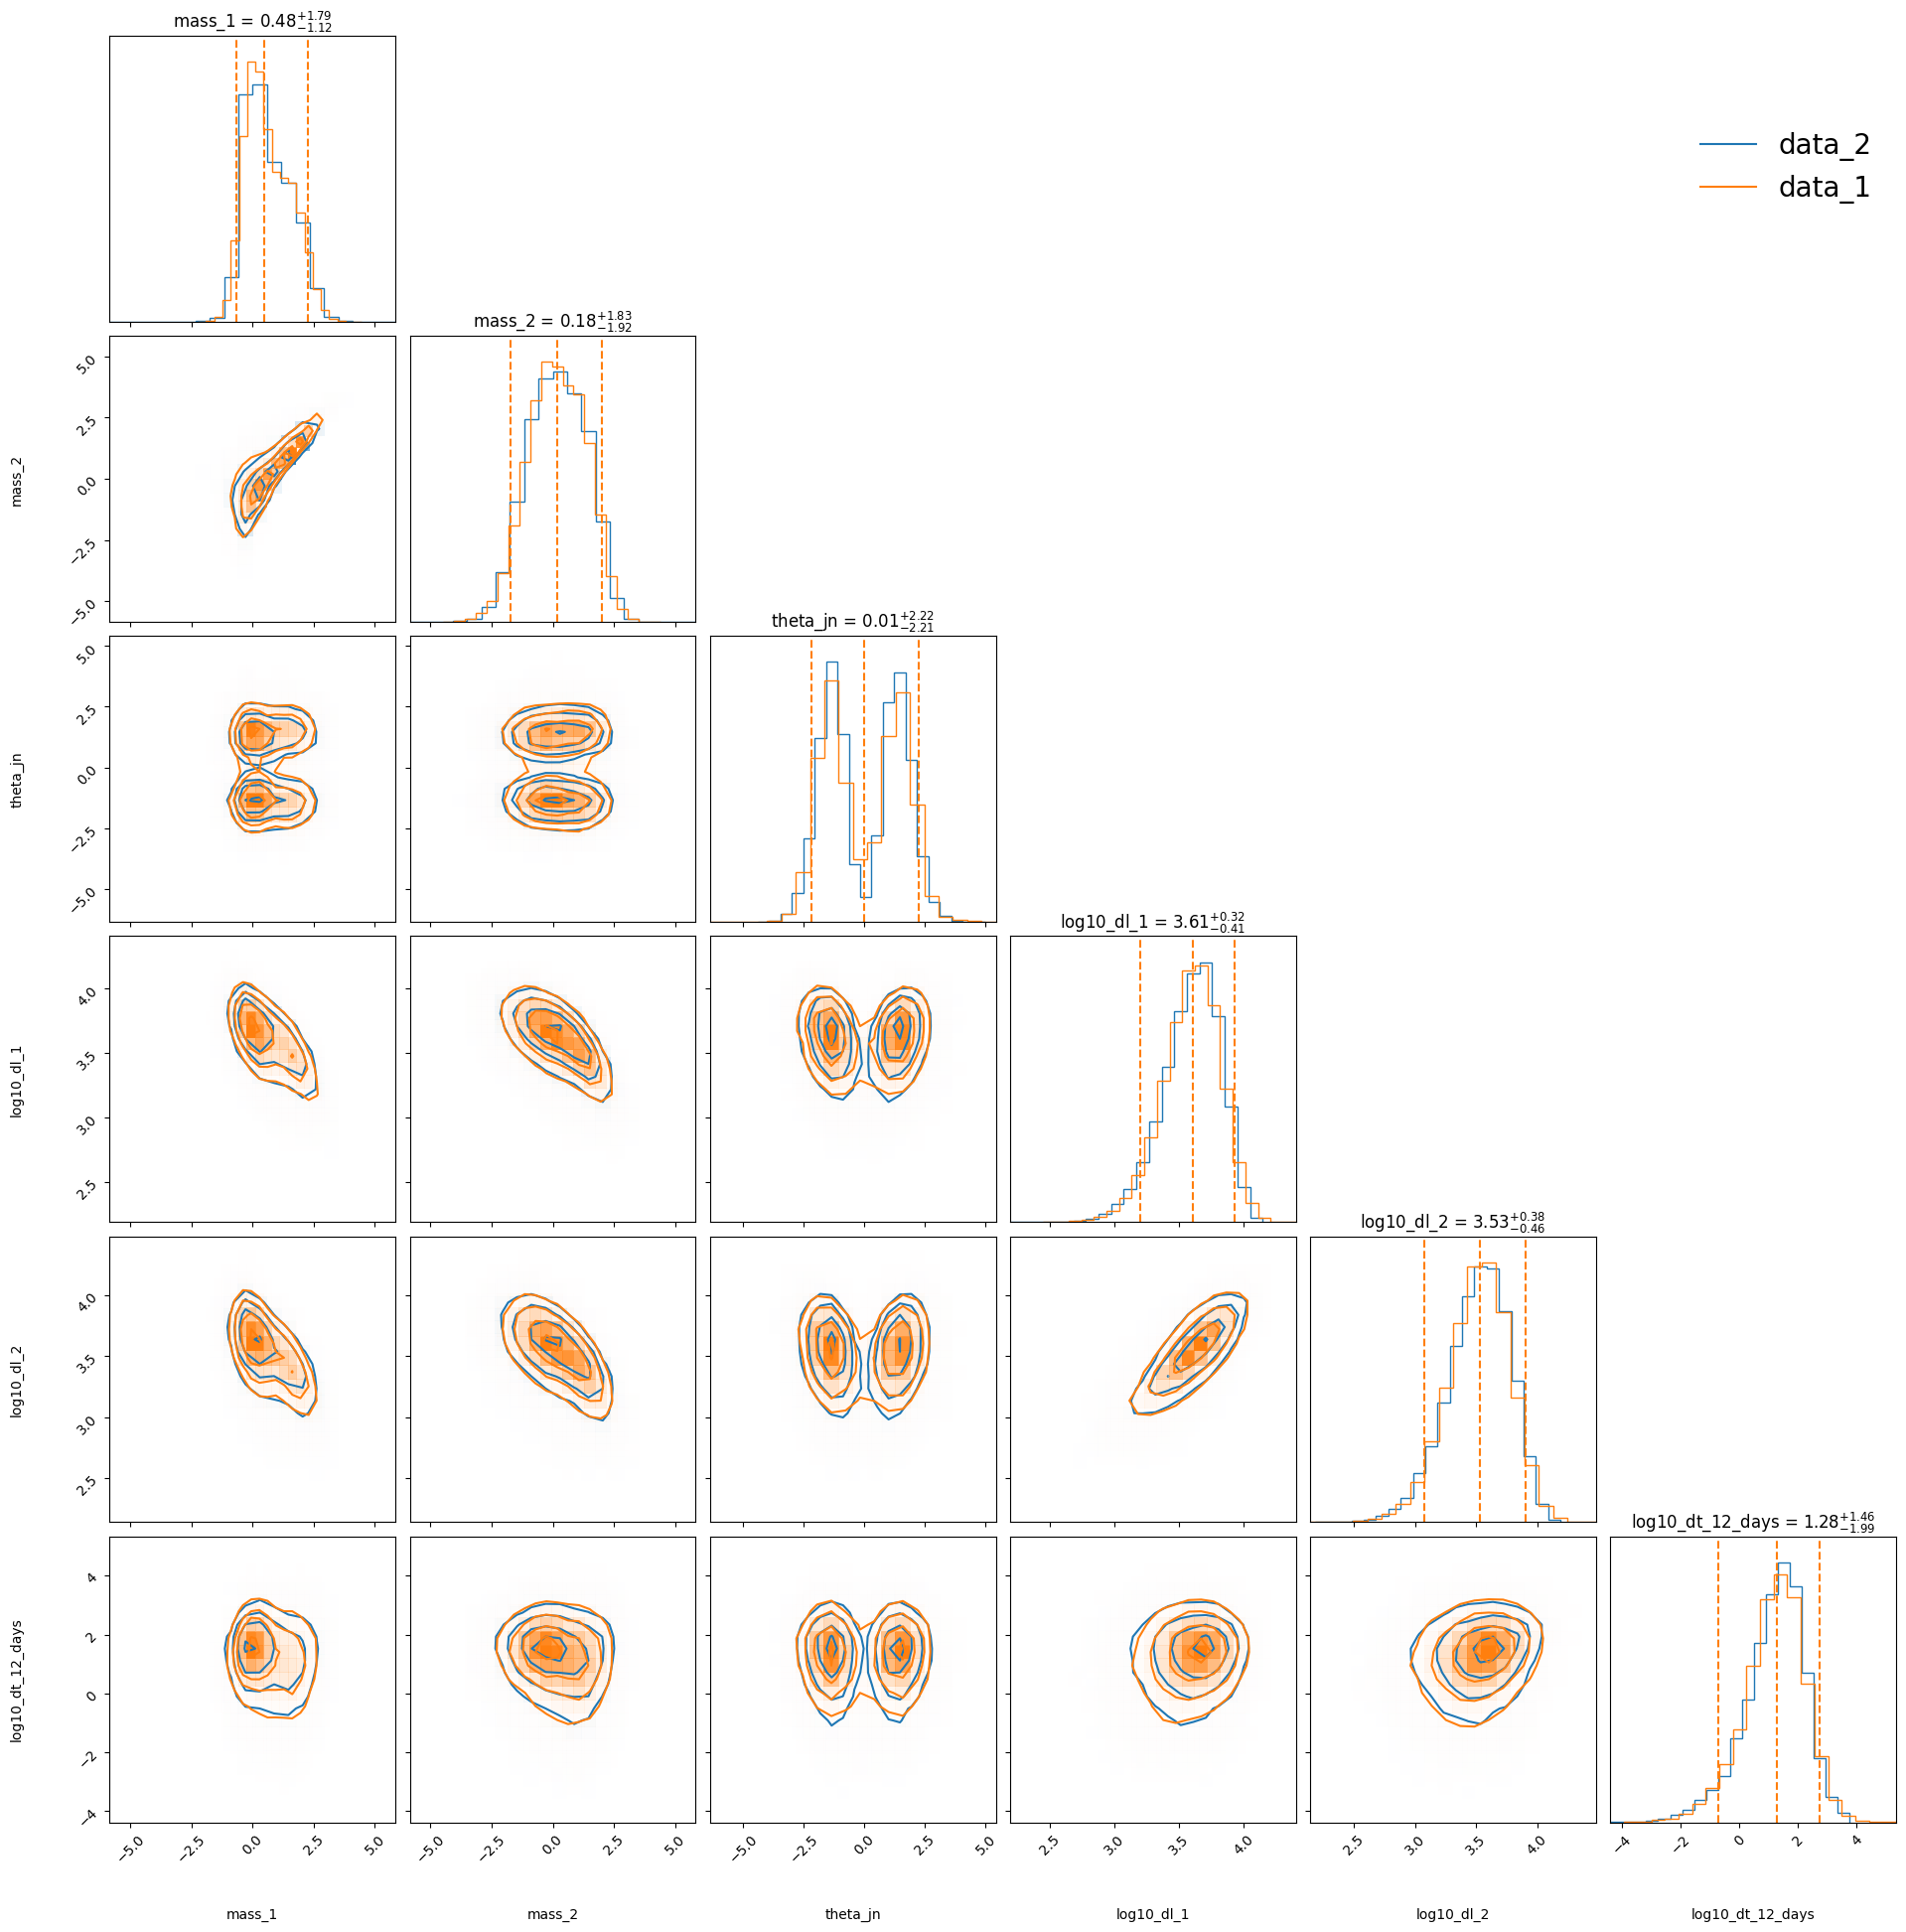

In [55]:
new_samples = dpgmm.sample(40000)[0]
# unscale data
new_samples = scaler.inverse_transform(new_samples)


new_samples_dict = dict(
    mass_1 = new_samples[:,0],
    mass_2 = new_samples[:,1],
    theta_jn = new_samples[:,2],
    log10_dl_1 = new_samples[:,3],
    log10_dl_2 = new_samples[:,4],
    log10_dt_12_days = new_samples[:,5],
)
train_data_dict = dict(
    mass_1 = train_data_[:,0],
    mass_2 = train_data_[:,1],
    theta_jn = train_data_[:,2],
    log10_dl_1 = train_data_[:,3],
    log10_dl_2 = train_data_[:,4],
    log10_dt_12_days = train_data_[:,5],
)

test1.plot(new_samples_dict, train_data_dict)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pobs.utils import save_json, load_json, data_check_astro_lensed_dpgmm, data_check_astro_lensed_sky_dpgmm, data_check_astro_unlensed_dpgmm, data_check_astro_unlensed_time_dpgmm 
from pobs.modelgenerator_dpgmm import ModelGenerator

data_dict = load_json('/Users/phurailatpamhemantakumar/phd/mypackages/pobs/pobs/data/n_unlensed_detectable_bbh_po_spin.json')
# data_dict = load_json('/Users/phurailatpamhemantakumar/phd/po-tutorial-2022/ler_data/n_unlensed_detectable_bbh_po_spin.json')
data_dict = data_check_astro_unlensed_time_dpgmm(data_dict, size=100000)

In [2]:
test = ModelGenerator(
    model_name='astro_unlensed_time', 
    create_new=True,
    n_components=20,
    weight_concentration_prior=1e-2,
    max_iter=1000,
    random_state=42,
    )

astro_unlensed is None
getting default astro_unlensed data_dict from pobs module


/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


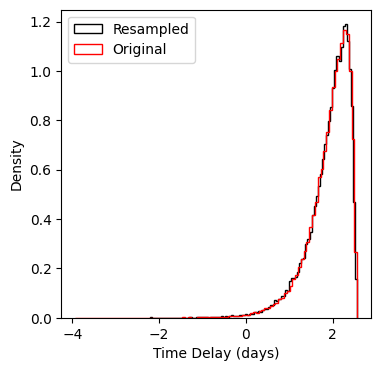

In [10]:
new_samples = test.resample(50000)

plt.figure(figsize=(4, 4))
plt.hist(new_samples['log10_dt_12_days'], bins=100, histtype='step', color='black', label='Resampled', density=True)
plt.hist(data_dict['log10_dt_12_days'], bins=100, histtype='step', color='red', label='Original', density=True)
plt.xlabel('Time Delay (days)')
plt.ylabel('Density')
plt.legend()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'hist'

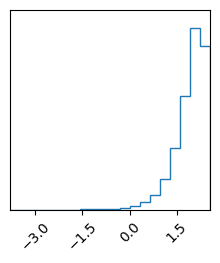

In [3]:
new_samples = test.resample(50000)
test.plot(new_samples, data_dict)

In [10]:
# from pobs.utils import save_min_max, load_json
# filename = test.meta_dict["min_max_path"]
# # min_max = save_min_max(filename, test.data_dict)
# # test.min_max = min_max
# min_max = load_json(filename)

In [9]:
# new_samples_x,_ = test.scaling(data_dict=test.data_dict, which_type="forward")
# test.plot(new_samples_x)

In [27]:
# new_samples,_ = test.scaling(data_dict=new_samples, which_type="backward")
# test.plot(new_samples)

In [3]:
data = test.model.sample(40000)[0]
new_samples = {}
j=0
for key in test.meta_dict['scaling_param'].keys():
    new_samples[key] = np.array(data[:,j])
    j+=1
new_samples, _ = test.scaling(data_list=data, which_type="backward")

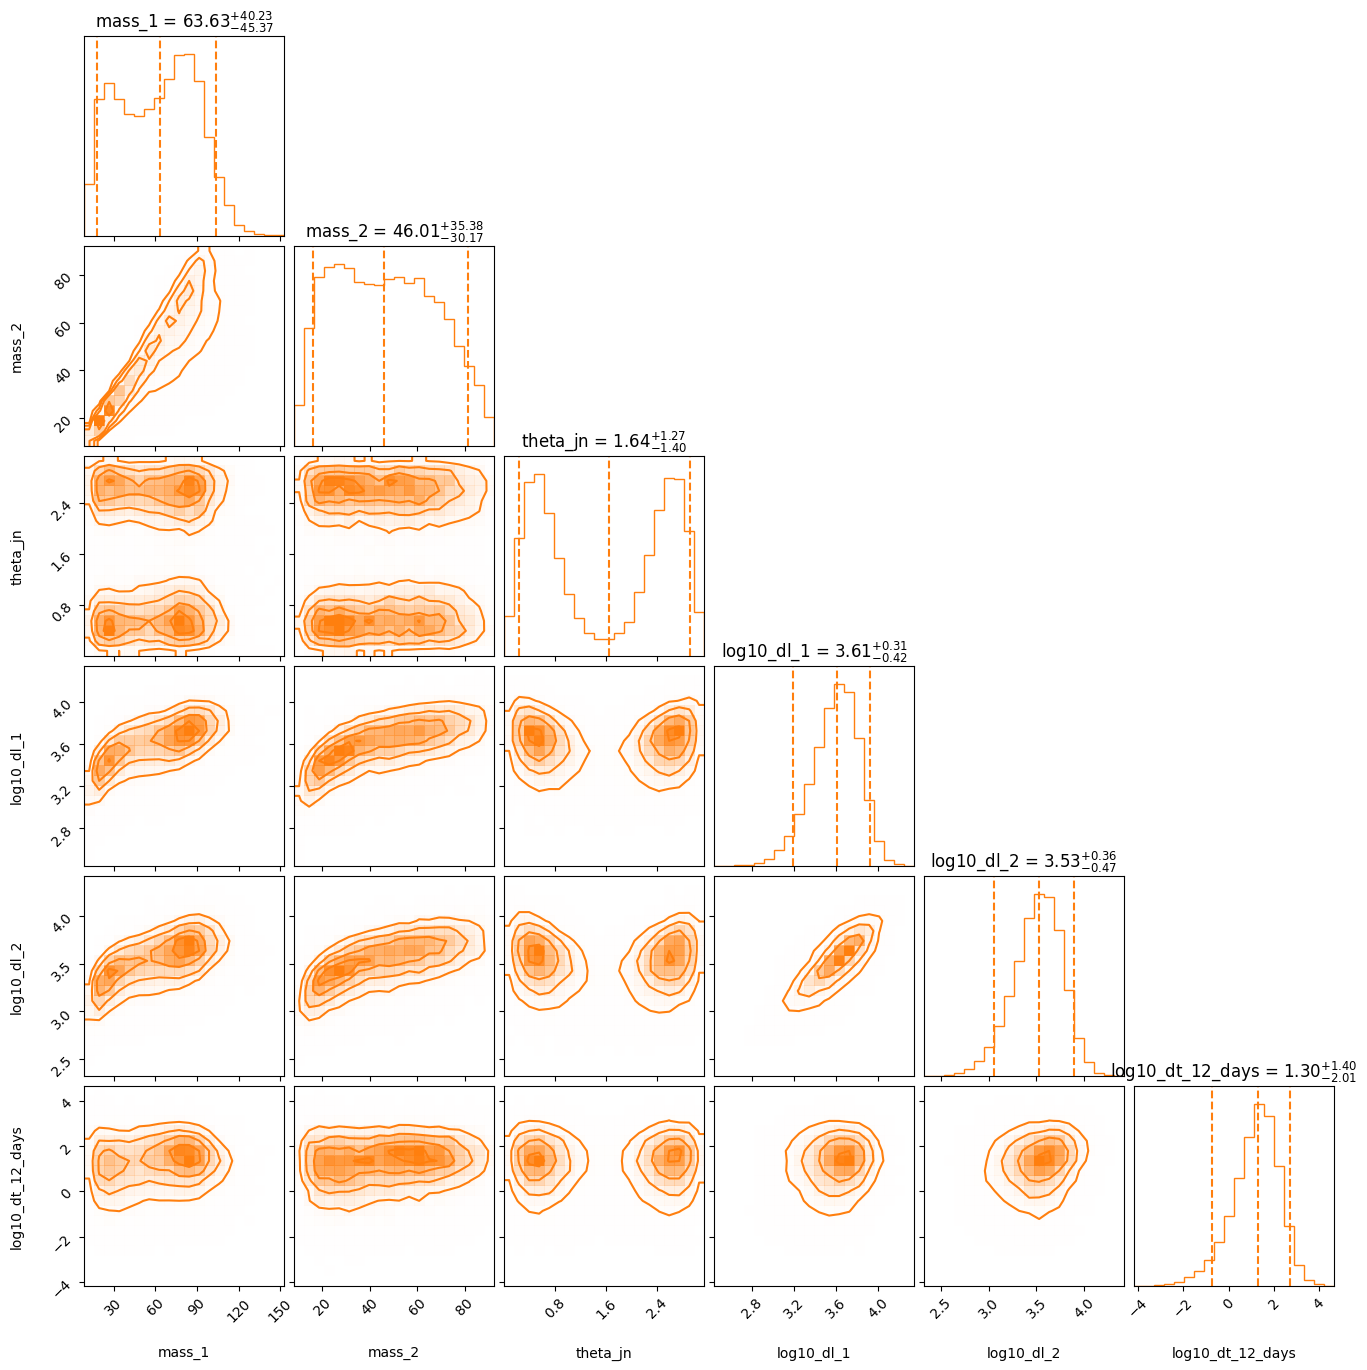

In [4]:
test.plot(new_samples)